In [1]:
import numpy as np
import terra

from meerkat.contrib.eeg import build_stanford_eeg_dp

from domino.emb.eeg import generate_words_dp, embed_words, embed_eeg
from domino.evaluate import run_sdms, score_sdm_explanations, score_sdms, run_sdm
from domino.sdm import MixtureModelSDM, SpotlightSDM
from domino.slices import collect_settings
from domino.train import score_settings, synthetic_score_settings, train_settings
from domino.utils import split_dp, balance_dp

import meerkat as mk
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, confusion_matrix, accuracy_score, roc_auc_score


/home/ksaab/Documents/meerkat/meerkat/nn/__init__.py:7: ExperimentalWarning: The `meerkat.nn` module is experimental and has limited test coverage. Proceed with caution.
  warnings.warn(


In [2]:
setting_dp = collect_settings.out(load=True)
setting_dp

,alpha (NumpyArrayColumn),build_setting_kwargs (ListColumn),dataset (PandasSeriesColumn),slice_category (PandasSeriesColumn),slice_names (ListColumn),target_name (PandasSeriesColumn),index (PandasSeriesColumn),setting_id (PandasSeriesColumn)
0,0.1,"{'target_frac': 0.5, 'error_rate': 0.1, 'n': 8000, 'attribute': 'age', 'attribute_thresh': 1}",eeg,noisy_label,['age<1'],sz,0,34694fdb-616b-4c11-8bf7-ac162982f47e
1,0.2,"{'target_frac': 0.5, 'error_rate': 0.2, 'n': 8000, 'attribute': 'age', 'attribute_thresh': 1}",eeg,noisy_label,['age<1'],sz,1,d610a10d-f1ca-4ee7-9765-5f07ea1aa9d6
2,0.3,"{'target_frac': 0.5, 'error_rate': 0.30000000000000004, 'n': 8000, 'attribute': 'age', 'attribute_thresh': 1}",eeg,noisy_label,['age<1'],sz,2,6a459eda-9c82-41f7-bc31-049cd4e01ca3
3,0.4,"{'target_frac': 0.5, 'error_rate': 0.4, 'n': 8000, 'attribute': 'age', 'attribute_thresh': 1}",eeg,noisy_label,['age<1'],sz,3,d79891a5-8462-420e-be5b-45b4d12eb1c5
4,0.5,"{'target_frac': 0.5, 'error_rate': 0.5, 'n': 8000, 'attribute': 'age', 'attribute_thresh': 1}",eeg,noisy_label,['age<1'],sz,4,02867608-b16b-435b-9bee-73086e577aba


In [3]:
run_sdms_dp = run_sdms.out(load=True)
run_sdms_dp.head()

,score_model_run_id (PandasSeriesColumn),train_model_run_id (PandasSeriesColumn),setting_id (PandasSeriesColumn),alpha (NumpyArrayColumn),dataset (PandasSeriesColumn),slice_names (ListColumn),slice_category (PandasSeriesColumn),index (PandasSeriesColumn),target_name (PandasSeriesColumn),build_setting_kwargs (ListColumn),train_settings_run_id (PandasSeriesColumn),score_settings_run_id (PandasSeriesColumn),synthetic_preds (PandasSeriesColumn),run_sdm_run_id (PandasSeriesColumn),emb_group (PandasSeriesColumn),time_this_iter_s (PandasSeriesColumn),done (PandasSeriesColumn),timesteps_total (PandasSeriesColumn),episodes_total (PandasSeriesColumn),training_iteration (PandasSeriesColumn),experiment_id (PandasSeriesColumn),date (PandasSeriesColumn),timestamp (PandasSeriesColumn),time_total_s (PandasSeriesColumn),pid (PandasSeriesColumn),hostname (PandasSeriesColumn),node_ip (PandasSeriesColumn),time_since_restore (PandasSeriesColumn),timesteps_since_restore (PandasSeriesColumn),iterations_since_restore (PandasSeriesColumn),trial_id (PandasSeriesColumn),sdm_config/weight_y_log_likelihood (PandasSeriesColumn),sdm_config/n_clusters (PandasSeriesColumn),sdm_config/n_slices (PandasSeriesColumn),sdm_config/emb (PandasSeriesColumn),sdm_config/xmodal_emb (PandasSeriesColumn),config/sdm (PandasSeriesColumn),config/slice (PandasSeriesColumn),logdir (PandasSeriesColumn),sdm_class (PandasSeriesColumn)
0,4003,3964.0,b7d6ad46-a42f-4eb0-a906-4af734d000b9,0.0,eeg,"['sz=0_age>1', 'sz=1_age<1']",correlation,0,sz,"{'correlate': 'age', 'corr': 0.0, 'correlate_threshold': 1, 'n': 8000}",3960.0,4002,False,4029,eeg,8.032663,False,NaN,NaN,1,c4c9275895bd47509db64cdf443660fd,2021-10-02_10-39-25,1633196365,8.032663,23801,gemini1,171.65.28.88,8.032663,0,1,9dd85_00000,10.0,10.0,10,emb,emb,"{'sdm_class': '', 'sdm_config': {'emb': ['eeg', 'emb'], 'n_clusters': 10.0, 'n_slices': 10, 'weight_y_log_likelihood': 10.0, 'xmodal_emb': 'emb'}}","{'alpha': 0.0, 'build_setting_kwargs': {'attribute': None, 'attribute_thresh': None, 'corr': 0.0, 'correlate': 'age', 'correlate_threshold': 1.0, 'error_rate': None, 'n': 8000, 'slice_frac': None, 'target_frac': None}, 'dataset': 'eeg', 'index': '0', 'score_model_run_id': 4003, 'score_settings_run_id': 4002, 'setting_id': 'b7d6ad46-a42f-4eb0-a906-4af734d000b9', 'slice_category': 'correlation', 'slice_names': ['sz=0_age>1', 'sz=1_age<1'], 'synthetic_preds': 'False', 'target_name': 'sz', 'train_model_run_id': 3964.0, 'train_settings_run_id': 3960.0}","/media/4tb_hdd/terra/slice/tasks/evaluate/run_sdms/_runs/4019/_evaluate_2021-10-02_10-38-55/_evaluate_9dd85_00000_0_sdm={'sdm_class': , 'sdm_config': {'weight_y_log_likelihood': 10, _2021-10-02_10-38-56",domino.sdm.gmm.MixtureModelSDM
1,4003,3964.0,b7d6ad46-a42f-4eb0-a906-4af734d000b9,0.0,eeg,"['sz=0_age>1', 'sz=1_age<1']",correlation,1,sz,"{'correlate': 'age', 'corr': 0.0, 'correlate_threshold': 1, 'n': 8000}",3960.0,4002,False,4030,multimodal,6.774118,False,NaN,NaN,1,22693804af6848d2a279e1a181004696,2021-10-02_10-39-24,1633196364,6.774118,23830,gemini1,171.65.28.88,6.774118,0,1,9dd85_00001,10.0,10.0,10,emb,emb,"{'sdm_class': '', 'sdm_config': {'emb': ['multimodal', 'emb'], 'n_clusters': 10.0, 'n_slices': 10, 'weight_y_log_likelihood': 10.0, 'xmodal_emb': 'emb'}}","{'alpha': 0.0, 'build_setting_kwargs': {'attribute': None, 'attribute_thresh': None, 'corr': 0.0, 'correlate': 'age', 'correlate_threshold': 1.0, 'error_rate': None, 'n': 8000, 'slice_frac': None, 'target_frac': None}, 'dataset': 'eeg', 'index': '0', 'score_model_run_id': 4003, 'score_settings_run_id': 4002, 'setting_id': 'b7d6ad46-a42f-4eb0-a906-4af734d000b9', 'slice_category': 'correlation', 'slice_names': ['sz=0_age>1', 'sz=1_age<1'], 'synthetic_preds': 'False', 'target_name': 'sz', 'train_model_run_id': 3964.0, 'train_settings_run_id': 3960.0}","/media/4tb_hdd/terra/slice/tasks/evaluate/run_sdms/_runs/4019/_evaluate_2021-10-02_10-38-55/_evaluate_9dd85_00001_1_sdm={'sdm_class': , 'sdm_config': {'weight_y_log_likelihood': 1

In [4]:
score_dp = mk.DataPanel.from_pandas(score_sdms.out(load=True))
score_dp

,pred_slice_idx (PandasSeriesColumn),slice_idx (PandasSeriesColumn),auroc (PandasSeriesColumn),precision_at_10 (PandasSeriesColumn),precision_at_25 (PandasSeriesColumn),precision_at_100 (PandasSeriesColumn),recall_at_50 (PandasSeriesColumn),recall_at_100 (PandasSeriesColumn),recall_at_200 (PandasSeriesColumn),recall (PandasSeriesColumn),precision (PandasSeriesColumn),target_name (PandasSeriesColumn),run_sdm_run_id (PandasSeriesColumn),score_model_run_id (PandasSeriesColumn),slice_name (PandasSeriesColumn),index (PandasSeriesColumn)
0,0.0,0.0,0.229254,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,sz,4029.0,4003.0,sz=0_age>1,0
1,1.0,0.0,0.846476,0.3,0.16,0.25,0.074257,0.123762,0.366337,0.004950,0.200000,sz,4029.0,4003.0,sz=0_age>1,1
2,2.0,0.0,0.822132,0.8,0.80,0.71,0.000000,0.405941,0.688119,0.470297,0.698529,sz,4029.0,4003.0,sz=0_age>1,2
3,3.0,0.0,0.485052,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,sz,4029.0,4003.0,sz=0_age>1,3
4,4.0,0.0,0.651525,0.1,0.16,0.31,0.064356,0.153465,0.292079,0.000000,0.000000,sz,4029.0,4003.0,sz=0_age>1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,5.0,0.0,0.500000,0.1,0.08,0.17,0.000000,0.000000,0.000000,0.000000,0.000000,sz,4135.0,4017.0,age<1,1505
1506,6.0,0.0,0.500000,0.1,0.08,0.17,0.000000,0.000000,0.000000,0.000000,0.000000,sz,4135.0,4017.0,age<1,1506
1507,7.0,0.0,0.500000,0.1,0.08,0.17,0.000000,0.000000,0.000000,0.000000,0.000000,sz,4135.0,4017.0,age<1,1507
1508,8.0,0.0,0.500000,0.1,0.08,0.17,0.000000,0.000000,0.000000,0.000000,0.000000,sz,4135.0,4017.0,age<1,1508


In [5]:
results_dp = mk.merge(
    score_dp,
    run_sdms_dp["sdm_class", "config/sdm", "alpha", "run_sdm_run_id", "build_setting_kwargs", "slice_category"], # include any other columns here you'd like to analyze
    on="run_sdm_run_id"
)
emb_col = results_dp["config/sdm"].map(lambda x: x["sdm_config"]["emb"][0])
results_dp["emb_type"] = emb_col

corr_thresh_col = results_dp["build_setting_kwargs"].map(lambda x: x["correlate_threshold"] if "correlate_threshold" in x else x["attribute_thresh"])
results_dp["corr_thresh"] = corr_thresh_col


results_df = results_dp.to_pandas()
results_df

,run_sdm_run_id,pred_slice_idx,slice_idx,auroc,precision_at_10,precision_at_25,precision_at_100,recall_at_50,recall_at_100,recall_at_200,...,score_model_run_id,slice_name,index,sdm_class,config/sdm,alpha,build_setting_kwargs,slice_category,emb_type,corr_thresh
0,4029,0,0,0.229254,0.0,0.00,0.00,0.000000,0.000000,0.000000,...,4003,sz=0_age>1,0,domino.sdm.gmm.MixtureModelSDM,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.0,"{'correlate': 'age', 'corr': 0.0, 'correlate_t...",correlation,eeg,1
1,4029,1,0,0.846476,0.3,0.16,0.25,0.074257,0.123762,0.366337,...,4003,sz=0_age>1,1,domino.sdm.gmm.MixtureModelSDM,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.0,"{'correlate': 'age', 'corr': 0.0, 'correlate_t...",correlation,eeg,1
2,4029,2,0,0.822132,0.8,0.80,0.71,0.000000,0.405941,0.688119,...,4003,sz=0_age>1,2,domino.sdm.gmm.MixtureModelSDM,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.0,"{'correlate': 'age', 'corr': 0.0, 'correlate_t...",correlation,eeg,1
3,4029,3,0,0.485052,0.0,0.00,0.00,0.000000,0.000000,0.000000,...,4003,sz=0_age>1,3,domino.sdm.gmm.MixtureModelSDM,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.0,"{'correlate': 'age', 'corr': 0.0, 'correlate_t...",correlation,eeg,1
4,4029,4,0,0.651525,0.1,0.16,0.31,0.064356,0.153465,0.292079,...,4003,sz=0_age>1,4,domino.sdm.gmm.MixtureModelSDM,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.0,"{'correlate': 'age', 'corr': 0.0, 'correlate_t...",correlation,eeg,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,4135,5,0,0.500000,0.1,0.08,0.17,0.000000,0.000000,0.000000,...,4017,age<1,1505,domino.sdm.confusion.ConfusionSDM,{'sdm_class': '<class 'domino.sdm.confusion.Co...,0.5,"{'target_frac': 0.5, 'error_rate': 0.5, 'n': 8...",noisy_label,multimodal,1
1506,4135,6,0,0.500000,0.1,0.08,0.17,0.000000,0.000000,0.000000,...,4017,age<1,1506,domino.sdm.confusion.ConfusionSDM,{'sdm_class': '<class 'domino.sdm.confusion.Co...,0.5,"{'target_frac': 0.5, 'error_rate': 0.5, 'n': 8...",noisy_label,multimodal,1
1507,4135,7,0,0.500000,0.1,0.08,0.17,0.000000,0.000000,0.000000,...,4017,age<1,1507,domino.sdm.confusion.ConfusionSDM,{'sdm_class': '<class 'domino.sdm.confusion.Co...,0.5,"{'target_frac': 0.5, 'error_rate': 0.5, 'n': 8...",noisy_label,multimodal,1
1508,4135,8,0,0.500000,0.1,0.08,0.17,0.000000,0.000000,0.000000,...,4017,age<1,1508,domino.sdm.confusion.ConfusionSDM,{'sdm_class': '<class 'domino.sdm.confusion.Co...,0.5,"{'target_frac': 0.5, 'error_rate': 0.5, 'n': 8...",noisy_label,multimodal,1


<ipython-input-6-0335ade20499>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df["success"] = grouped_df["precision_at_10"] > 0.6


151


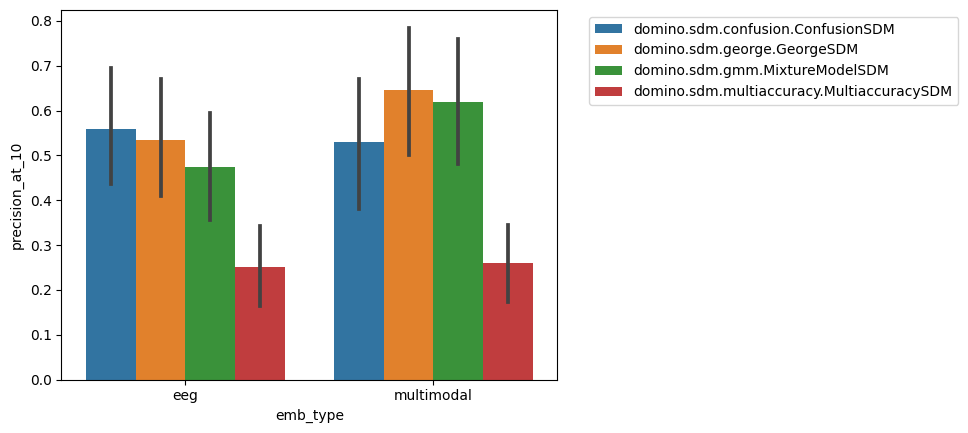

In [6]:
metric = "precision_at_10"
grouped_df = results_df.iloc[results_df.reset_index().groupby(["sdm_class", "slice_name", "slice_idx","emb_type", "alpha", "corr_thresh", "slice_category"])[metric].idxmax().astype(int)]

grouped_df["success"] = grouped_df["precision_at_10"] > 0.6

print(len(grouped_df))
#ax = sns.lineplot(data=grouped_df,x="alpha",y=metric, hue="emb_type",style="slice_name")
#ax = sns.violinplot(data=grouped_df,x=metric,y="emb_type")
ax = sns.barplot(data=grouped_df,y=metric,x="emb_type",hue="sdm_class")
#ax = sns.displot(data=grouped_df,x=metric,hue="sdm_class")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In [7]:
# metric = "auroc"
# grouped_df = results_df.iloc[results_df.reset_index().groupby(["sdm_class", "slice_name", "slice_idx","emb_type","alpha","corr_thresh"])[metric].idxmax().astype(int)]


# #ax = sns.lineplot(data=grouped_df,x="alpha",y=metric, hue="emb_type",style="slice_name")
# ax = sns.barplot(data=grouped_df,x=metric,y="slice_category",hue="sdm_class")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()

In [8]:
specific_run = grouped_df[grouped_df["emb_type"]=="multimodal"][grouped_df["slice_idx"]==0][grouped_df["alpha"]==0][grouped_df["sdm_class"]=="domino.sdm.confusion.ConfusionSDM"]
specific_run

<ipython-input-8-2102573fa2db>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  specific_run = grouped_df[grouped_df["emb_type"]=="multimodal"][grouped_df["slice_idx"]==0][grouped_df["alpha"]==0][grouped_df["sdm_class"]=="domino.sdm.confusion.ConfusionSDM"]


,run_sdm_run_id,pred_slice_idx,slice_idx,auroc,precision_at_10,precision_at_25,precision_at_100,recall_at_50,recall_at_100,recall_at_200,...,slice_name,index,sdm_class,config/sdm,alpha,build_setting_kwargs,slice_category,emb_type,corr_thresh,success
140,4032,0,0,0.889795,0.4,0.32,0.4,0.084158,0.19802,0.480198,...,sz=0_age>1,140,domino.sdm.confusion.ConfusionSDM,{'sdm_class': '<class 'domino.sdm.confusion.Co...,0.0,"{'correlate': 'age', 'corr': 0.0, 'correlate_t...",correlation,multimodal,1,False


In [9]:
sdm_dp, _ = run_sdm.out(specific_run["run_sdm_run_id"].values[0],load=True)
sdm_dp.head()

,id (PandasSeriesColumn),file_id (PandasSeriesColumn),age (NumpyArrayColumn),fm_split (PandasSeriesColumn),sz_start_index (NumpyArrayColumn),index (PandasSeriesColumn),filepath (PandasSeriesColumn),input (LambdaColumn),target (NumpyArrayColumn),duration (NumpyArrayColumn),binarized_age (NumpyArrayColumn),slices (NumpyArrayColumn),split (PandasSeriesColumn),output (ClassificationOutputColumn),probs (ClassificationOutputColumn),pred_slices (NumpyArrayColumn),emb (NumpyArrayColumn)
0,ZA002115_1-1+_0.0,ZA002115_1-1+,26.378950,train,0.0,7981,/media/4tb_hdd/eeg_data/stanford/stanford_mini/ZA002115_1-1+.eeghdf,"LambdaCell(fn=functools.partial(, clip_len=12))",True,2402.0,1,"np.ndarray(shape=(2,))",test,torch.Tensor(shape=torch.Size([2])),torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(10,))","np.ndarray(shape=(128,))"
1,CA83139O_1-15+_2.0,CA83139O_1-15+,0.154193,train,2.0,2728,/media/4tb_hdd/eeg_data/lpch/lpch/CA83139O_1-15+.eeghdf,"LambdaCell(fn=functools.partial(, clip_len=12))",True,463.0,0,"np.ndarray(shape=(2,))",test,torch.Tensor(shape=torch.Size([2])),torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(10,))","np.ndarray(shape=(128,))"
2,CA83139O_1-15+_1.0,CA83139O_1-15+,0.154193,train,1.0,2728,/media/4tb_hdd/eeg_data/lpch/lpch/CA83139O_1-15+.eeghdf,"LambdaCell(fn=functools.partial(, clip_len=12))",True,463.0,0,"np.ndarray(shape=(2,))",test,torch.Tensor(shape=torch.Size([2])),torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(10,))","np.ndarray(shape=(128,))"
3,FA34002R_1-3+_0.0,FA34002R_1-3+,0.397005,train,0.0,1681,/media/4tb_hdd/eeg_data/lpch/lpch/FA34002R_1-3+.eeghdf,"LambdaCell(fn=functools.partial(, clip_len=12))",True,656.0,0,"np.ndarray(shape=(2,))",test,torch.Tensor(shape=torch.Size([2])),torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(10,))","np.ndarray(shape=(128,))"
4,FA34002R_1-3+_1.0,FA34002R_1-3+,0.397005,train,1.0,1681,/media/4tb_hdd/eeg_data/lpch/lpch/FA34002R_1-3+.eeghdf,"LambdaCell(fn=functools.partial(, clip_len=12))",True,656.0,0,"np.ndarray(shape=(2,))",test,torch.Tensor(shape=torch.Size([2])),torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(10,))","np.ndarray(shape=(128,))"


In [10]:
from domino.slices.abstract import build_setting

specific_run = grouped_df[grouped_df["emb_type"]=="multimodal"][grouped_df["slice_idx"]==0][grouped_df["alpha"]==0][grouped_df["sdm_class"]=="domino.sdm.confusion.ConfusionSDM"]
sdm_dp, _ = run_sdm.out(specific_run["run_sdm_run_id"].values[0],load=True)

preds = np.array(sdm_dp.lz["probs"].argmax(1))
targets = np.array(sdm_dp.lz["target"])
in_slice = sdm_dp.lz["slices"][:,0]

print(targets.mean())
tn, fp, fn, tp = confusion_matrix(targets,preds,normalize="true").ravel()
print(f"FP: {fp}, FN: {fn}")

pred_slices = sdm_dp.lz["pred_slices"]
#for ndx in range(10):
ndx=1
pp = pred_slices[:,ndx]
pp = (targets==0)*np.array(sdm_dp.lz["probs"][:,1]>0.5)
#print(roc_auc_score(in_slice,pp))
print(precision_score(in_slice,pp))

#print((preds != targets).mean())
#print((preds[in_slice]!= targets[in_slice]).mean())
fns = np.array((targets==0)*(preds==1))
print(in_slice[fns].mean())

#synth_dp.head()

0.6453900709219859
FP: 0.4825, FN: 0.38873626373626374
0.5233160621761658
0.5233160621761658


<ipython-input-10-6ef34ff161e5>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  specific_run = grouped_df[grouped_df["emb_type"]=="multimodal"][grouped_df["slice_idx"]==0][grouped_df["alpha"]==0][grouped_df["sdm_class"]=="domino.sdm.confusion.ConfusionSDM"]


In [11]:
pred_slices.argmax(1).min()

0

In [12]:
# grouped_df["success"] = np.logical_and(grouped_df["auroc"] > 0.7, grouped_df["precision_at_10"] > 0.4)

# #ax = sns.pointplot(data=grouped_df,x="alpha",y="success", hue="emb_type", dodge=True, join=False)
# ax = sns.barplot(data=grouped_df,x="success",y="emb_type")

# plt.show()

# Explanations

In [13]:
words_dp = embed_words.out(load=True)

# get multimodal sdm run ids
slice_id = 0
alpha = 0.8

specific_run = grouped_df[grouped_df["emb_type"]=="multimodal"][grouped_df["slice_idx"]==slice_id][grouped_df["alpha"]==alpha]
specific_run

<ipython-input-13-32d934545db8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  specific_run = grouped_df[grouped_df["emb_type"]=="multimodal"][grouped_df["slice_idx"]==slice_id][grouped_df["alpha"]==alpha]


,run_sdm_run_id,pred_slice_idx,slice_idx,auroc,precision_at_10,precision_at_25,precision_at_100,recall_at_50,recall_at_100,recall_at_200,...,slice_name,index,sdm_class,config/sdm,alpha,build_setting_kwargs,slice_category,emb_type,corr_thresh,success
781,4063,1,0,0.966859,0.7,0.60,0.34,0.545455,0.772727,0.954545,...,sz=0_age>1,781,domino.sdm.confusion.ConfusionSDM,{'sdm_class': '<class 'domino.sdm.confusion.Co...,0.8,"{'correlate': 'age', 'corr': 0.8, 'correlate_t...",correlation,multimodal,1,True
741,4072,1,0,0.941704,0.2,0.36,0.28,0.386364,0.636364,0.886364,...,sz=0_age>1,741,domino.sdm.george.GeorgeSDM,{'sdm_class': '<class 'domino.sdm.george.Georg...,0.8,"{'correlate': 'age', 'corr': 0.8, 'correlate_t...",correlation,multimodal,1,False
661,4068,1,0,0.788769,0.4,0.28,0.24,0.431818,0.545455,0.727273,...,sz=0_age>1,661,domino.sdm.gmm.MixtureModelSDM,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.8,"{'correlate': 'age', 'corr': 0.8, 'correlate_t...",correlation,multimodal,1,False
700,4073,0,0,0.525272,0.0,0.00,0.01,0.022727,0.022727,0.113636,...,sz=0_age>1,700,domino.sdm.multiaccuracy.MultiaccuracySDM,{'sdm_class': '<class 'domino.sdm.multiaccurac...,0.8,"{'correlate': 'age', 'corr': 0.8, 'correlate_t...",correlation,multimodal,1,False


In [14]:
pred_slice_idx = specific_run["pred_slice_idx"].values[0]
_, expl_dp = run_sdm.out(specific_run["run_sdm_run_id"].values[0],load=True)
expl_dp[(-expl_dp["pred_slices"].data[:,pred_slice_idx]).argsort()][:10]

,word (PandasSeriesColumn),pred_slices (NumpyArrayColumn)
0,REASON FOR MONITORING: 15 month old boy with recent febrile seizure followed by a cluster of non-febrile seizures ACTIVE MEDICATION ORDERS (as of 10/15/2010 14:09):,"np.ndarray(shape=(10,))"
1,"Intractable epilepsy - stiffening, eyes rolling up, breathing stopping.","np.ndarray(shape=(10,))"
2,EEG monitoring to screen for subclinical seizures.,"np.ndarray(shape=(10,))"
3,"Last was on June 26, 2014 - tonic clonic movements with eyes rolling up.","np.ndarray(shape=(10,))"
4,This awake/asleep EEG is moderately abnormal with one burst of generalized 3Hz spike wave interictal epileptiform activity during sleep.,"np.ndarray(shape=(10,))"
5,"On 7/10, awoke slightly earlier than usual, had a loose stool, then wanted to go back to sleep, then awoke about 45 mins later, started to vomit then possibly had a seizure lasting less than a minute: Was thrashing about on the ground, slow respirations, and eyes rolled back.","np.ndarray(shape=(10,))"
6,"17 yo girl ex-35 weeker with IVH, cerebral palsy, and brief seizures consisting of right hand jerking, side-to-side head movements, with her eyes open and rolling in various directions","np.ndarray(shape=(10,))"
7,": Neonate: Seizures, multifocal sharp waves.","np.ndarray(shape=(10,))"
8,"Beginning approximately at 11AM in the record, interictal epileptiform sharp waves were present with maximal electronegativity and phase reversal near F7, T3, Fp1, and T1.","np.ndarray(shape=(10,))"
9,Correlating seizures noted on routine EEG (right body/leg seizures with left side seizures with most spikes at T4).,"np.ndarray(shape=(10,))"


In [15]:
expl_dp[(-expl_dp["pred_slices"].data[:,pred_slice_idx]).argsort()][10:20]

,word (PandasSeriesColumn),pred_slices (NumpyArrayColumn)
0,"Machine detection was used for spikes, rhythmical events and possible seizures.","np.ndarray(shape=(10,))"
1,"Machine detection was used for spikes, rhythmical events and possible seizures.","np.ndarray(shape=(10,))"
2,"Machine detection was used for spikes, rhythmical events and possible seizures.","np.ndarray(shape=(10,))"
3,"Machine detection was used for spikes, rhythmical events and possible seizures.","np.ndarray(shape=(10,))"
4,": Rana Lozani, NP History & Indication: 2 year old boy with 2 complex febrile seizures; one with head deviation to the right and another that was generalized and may have been 2 seizuers over 20 minutes","np.ndarray(shape=(10,))"
5,"3.5 year old boy with 2 episodes concerning for seizures, consisting of eyes rolling back, shaking for 30 seconds, and dazed afterwards.","np.ndarray(shape=(10,))"
6,REASON FOR MONITORING: 10 month old girl with new onset seizures (2 GTC x 1 min each) ACTIVE PRESCRIPTION ORDERS (as of 09/01/2010 15:35): none CONDITION OF RECORDING: 24-channel digital EEG performed using the International 10-20 system for electrode placement.,"np.ndarray(shape=(10,))"
7,"History: 24 year old man with refractory epilepsy, seizures consisting of head turning to the left, moaning, and loss of awareness.","np.ndarray(shape=(10,))"
8,"There are also events more likely to be epileptic with scared feelings, vomiting, stomach sensation.","np.ndarray(shape=(10,))"
9,18 moM full-term who presents with 3 episodes of febrile seizure lasting 1-2 minutes each.,"np.ndarray(shape=(10,))"


task: sdm_barplot, run_id=4171


/home/ksaab/Documents/domino/domino/plot.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df["alpha"] = grouped_df["alpha"].round(3)


<Figure size 640x480 with 0 Axes>

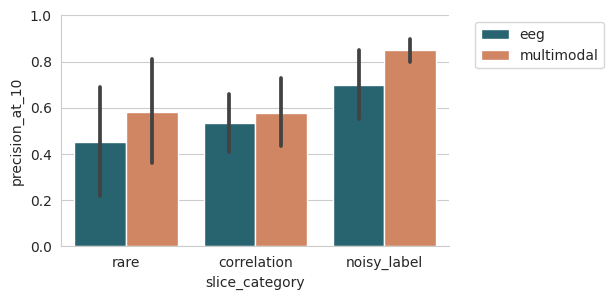

task: sdm_displot, run_id=4172


/home/ksaab/Documents/domino/domino/plot.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df["alpha"] = grouped_df["alpha"].round(3)
[2021-10-02 10:42:52,835][WARNING][matplotlib.legend:1225] :: No handles with labels found to put in legend.


<Figure size 640x480 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 200x2000 with 0 Axes>

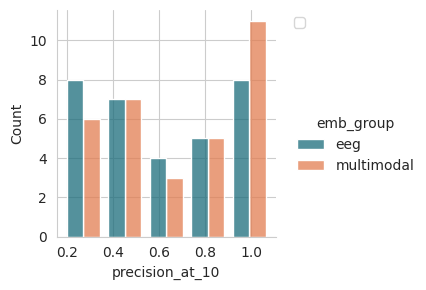

In [16]:
from domino.plot import sdm_barplot, sdm_displot
sdm_barplot(
    score_sdm_ids=[4170],
    emb_groups=["eeg", "multimodal"],
    sdm_classes=["domino.sdm.gmm.MixtureModelSDM"],
    run_dir="."
)
# sdm_barplot(
#     score_sdm_ids=[3918],
#     emb_groups=["multimodal"],
#     sdm_classes=["domino.sdm.gmm.MixtureModelSDM", "domino.sdm.multiaccuracy.MultiaccuracySDM"],
# )
plt.savefig("figures/sdm_barplot.pdf")
plt.show()

sdm_displot(
    score_sdm_ids=[4170], #synthetics: 3918
    emb_groups=["eeg", "multimodal"],
    sdm_classes=["domino.sdm.gmm.MixtureModelSDM"],
    run_dir="."
)
plt.savefig("figures/sdm_displot.pdf")
plt.show()